In [1]:
%load_ext autoreload
%autoreload 2

from zipfile import ZipFile
from matplotlib import pyplot as plt 
from PIL import Image
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder

sys.path.insert(1, './../Aula02/')
from src.train import get_all_subsets, results_binary


2023-10-29 16:47:52.973330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 16:47:54.224923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [3]:
source_file = './dataset/brain-cancer.zip'

In [4]:
zip_file = ZipFile(source_file)

In [5]:
def get_label(filename):
    parts = filename.lower().split('/')
    result = None
    if 'yes' in parts:
        result = 1
    elif 'no' in parts:
        result = 0
    else:
        pass
    
    return result

def get_image_array(filename):
    new_size = (224, 224)
    img_data = Image.open(zip_file.open(filename))
    img_array = np.array(img_data.resize(new_size), np.int8)
    if img_array.ndim == 1: 
        # Replicar o canal para imagens em escala de cinza
        img_array = np.expand_dims(img_array, axis = -1)
        img_array = np.concatenate([img_array] * 3, axis = -1)

    # normalizar
    img_array_normalized = (img_array - img_array.mean()) / img_array.std()

    return img_array_normalized


assert get_label('brain_tumor_dataset/no/30 no.jpg') == 0
assert get_label('brain_tumor_dataset/NO/31 no.jpg') == 0
assert get_label('yes/Y95.jpg') == 1
assert get_label('brain_tumor_dataset/yes/Y155.JPG') == 1
assert get_label('brain_tumor_dataset/Y155.JPG') == None

In [6]:
# process
images = []
labels = []
data_results_dict = []

for filename in zip_file.namelist():
    
    # get label 0 = no, 1 = yes
    label = get_label(filename)

    # get image array    
    img_array = get_image_array(filename) 
    
    # build a dict with data
    data_results_dict.append(
        {'filename': filename, 
         'label': label, 
         'img_array': img_array}
    )

    if img_array.shape == (224, 224, 3):
        # get X and y vars
        images.append(img_array)
        labels.append(label)


In [7]:
# all images have 3 channels
size = []
for a in images:
    size.append(len(a.shape))

np.unique(size, return_counts=True)

(array([3]), array([434]))

In [8]:
# y is unbalanced
np.unique(labels, return_counts=True)

(array([0, 1]), array([158, 276]))

In [9]:
# getting 
X_train, X_val, X_test, y_train, y_val, y_test = get_all_subsets(np.array(images), 
                                                                 np.array(labels))

In [10]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1,1)).toarray()
y_val = encoder.fit_transform(y_val.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1,1)).toarray()

In [11]:
print("Shape X_train: ", X_train.shape)
print("Shape X_val: ", X_val.shape)
print("Shape X_test: ", X_test.shape)

print("Shape y_train: ", y_train.shape)
print("Shape y_val: ", y_val.shape)
print("Shape y_test: ", y_test.shape)


Shape X_train:  (277, 224, 224, 3)
Shape X_val:  (70, 224, 224, 3)
Shape X_test:  (87, 224, 224, 3)
Shape y_train:  (277, 2)
Shape y_val:  (70, 2)
Shape y_test:  (87, 2)


In [27]:
trainloader = DataLoader(X_train, batch_size=32)
validloader = DataLoader(X_val, batch_size=32)
testloader = DataLoader(X_test, batch_size=32, shuffle=True, num_workers=2)

## Torch

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 3)
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(256, 16)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(2, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [24]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=256, out_features=16, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
  (fc4): Linear(in_features=2, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [25]:
# compile
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
min_valid_loss = np.inf

In [28]:
epochs = 100
for epoch in range(epochs):
    
    running_loss = 0.0
    train_loss = 0.0
    for data, labels in zip(trainloader, testloader):
        
        optimizer.zero_grad()

        target = net(data)

        loss = criterion(data, criterion)

        loss.backward()
    
    break

RuntimeError: Input type (double) and bias type (float) should be the same

In [160]:
rede_simples = Sequential()
rede_simples.add(Conv2D(filters=1, \
                        kernel_size=3, \
                        activation='relu', \
                        input_shape=[224,224,3]))

rede_simples.add(Flatten())
rede_simples.add(Dense(512, activation='relu'))
rede_simples.add(Dense(256, activation='relu'))
rede_simples.add(Dense(64, activation='relu'))
rede_simples.add(Dense(2, activation='softmax'))

In [161]:
rede_simples.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 1)       28        
                                                                 


 flatten_8 (Flatten)         (None, 49284)             0         
                                                                 
 dense_22 (Dense)            (None, 512)               25233920  
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 dense_24 (Dense)            (None, 64)                16448     
                                                                 
 dense_25 (Dense)            (None, 2)                 130       
                                                                 
Total params: 25381854 (96.82 MB)
Trainable params: 25381854 (96.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [163]:
rede_simples.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [164]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

history = rede_simples.fit(X_train, y_train, \
                           epochs=100, \
                            verbose=1, \
                            shuffle=True, \
                            batch_size=64, \
                            validation_data=(X_val, y_val), 
                            callbacks=[es])

Epoch 1/100
5/5 [==============================] - 4s 685ms/step - loss: 6.1018 - accuracy: 0.6318 - val_loss: 2.3576 - val_accuracy: 0.8143
Epoch 2/100
5/5 [==============================] - 3s 639ms/step - loss: 1.7201 - accuracy: 0.7437 - val_loss: 1.4294 - val_accuracy: 0.7571
Epoch 3/100
5/5 [==============================] - 3s 618ms/step - loss: 0.6884 - accuracy: 0.8700 - val_loss: 0.8436 - val_accuracy: 0.8429
Epoch 4/100
5/5 [==============================] - 3s 610ms/step - loss: 0.2507 - accuracy: 0.9531 - val_loss: 0.5397 - val_accuracy: 0.9000
Epoch 5/100
5/5 [==============================] - 3s 701ms/step - loss: 0.0780 - accuracy: 0.9928 - val_loss: 0.5404 - val_accuracy: 0.8714
Epoch 6/100
5/5 [==============================] - 3s 662ms/step - loss: 0.0401 - accuracy: 0.9964 - val_loss: 0.5783 - val_accuracy: 0.9143
Epoch 7/100
5/5 [==============================] - 3s 635ms/step - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.5269 - val_accuracy: 0.9143
Epoch 8/100
5

In [165]:
y_pred = rede_simples.predict(X_test)

3/3 [==============================] - 0s 67ms/step


In [168]:
results_binary(y_test.argmax(1), y_pred.argmax(1))
print('-- end')

Confusion Matrix :
[[34  3]
 [ 1 49]]
Report : 
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        37
           1       0.94      0.98      0.96        50

    accuracy                           0.95        87
   macro avg       0.96      0.95      0.95        87
weighted avg       0.95      0.95      0.95        87

Accuracy: 95.40%
-- end


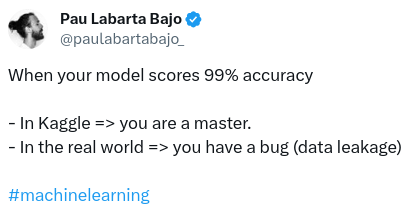

In [150]:
y_pred[:10], y_test[:10]


(array([[0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994]], dtype=float32),
 array([0, 0, 1, 0, 1, 1, 0, 1, 1, 1]))

In [152]:
y_pred

array([[0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.999